In [2]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import astropy as ast
from astropy import stats

import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [3]:
session_info = {'date': "20_01_2024",
                'genotype_dir': 'ER4d_sytjGCaMP7f_attp2',
                'fly': 'fly3',
                'session': 'closed_loop-002',
                'full_genotype': '+/w-; +/ER4d-AD; UAS-sytjGCaMP7f^{attp2}/ER4d-DBD (SS00238)',
                'ecl date': '1/10/2024',
                'notes':''}

bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
fictrac_folder = pathlib.PurePath('/media/mplitt/SSD_storage/fictrac_folder')
                            

pp = st2p.preprocessing.EBImagingSession(session_info = session_info, 
                                         bruker_base_dir = bruker_folder,
                                         fictrac_base_dir = fictrac_folder)

In [ ]:
pp.extract_metadata()
pp.bruker_to_h5(first_chan=2, overwrite=False)
data_corr, shifts, error, diffphase= pp.motion_correct(pp.data)
pp.align_voltage_recording()
nap = pp.open_napari()

In [ ]:
nap = pp.open_napari(check_for_existing=False)

In [5]:
print('next')

next


In [3]:
if True:
    gd = session_info['genotype_dir']
    d = session_info['date']
    f = session_info['fly']
    s = session_info['session']
    outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    nap = pp.open_napari()

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


In [4]:
n_rois = 16
nap.make_phase_masks(n_rois=n_rois)
pp.get_layers(nap)
pp.extract_timeseries(max_proj=False)

In [5]:
y = pp.calculate_zscored_F('rois', exp_detrend=True,zscore=False)

In [6]:
pp.save()

In [4]:
if True:
    gd = session_info['genotype_dir']
    d = session_info['date']
    f = session_info['fly']
    s = session_info['session']
    outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    y = pp.timeseries['rois_z']
    n_rois=y.shape[1]
    pp.extract_timeseries(max_proj=False)
    y = pp.calculate_zscored_F('rois', exp_detrend=True,zscore=False)

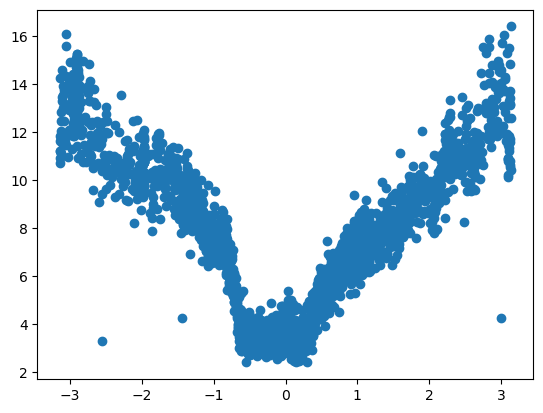

In [5]:
fig, ax = plt.subplots()
heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
ax.scatter(-1*pp.voltage_recording_aligned[' Heading'].to_numpy(), pp.timeseries['background'])
mask = np.abs(heading)> 1.5

In [6]:
# y_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y-1, 1, axis=-1),.7,axis=1, mode='wrap')
y_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(1-y, 2, axis=-1),1,axis=1, mode='wrap')
# heading = sp.ndimage.gaussian_filter1d(sp.ndimage.median_filter(heading,(5,)),2)
# y_sm = -y

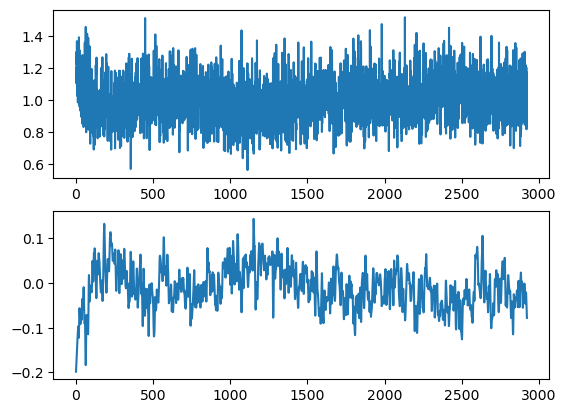

In [7]:
fig, ax = plt.subplots(2,1)
ax[0].plot((y)[0,1,:])
ax[1].plot(y_sm[0,1,:])


In [12]:
x_f,y_f = st2p.utilities.pol2cart(y_sm[0,:,:] ,np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
print(rho.shape, phi.shape)

heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
_,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))

(2924,) (2924,)


0.05076873290214053


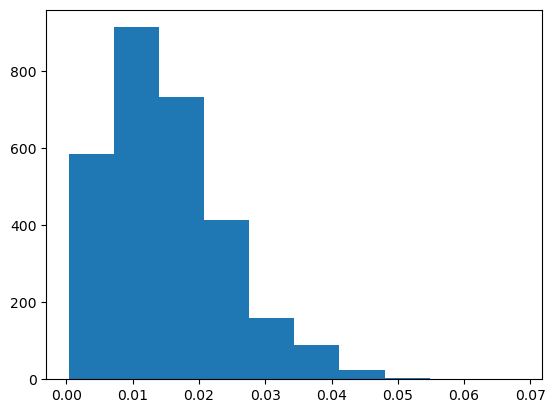

In [13]:
fig, ax = plt.subplots()
ax.hist(rho)

r = ast.stats.circcorrcoef(phi, heading)
print(r)

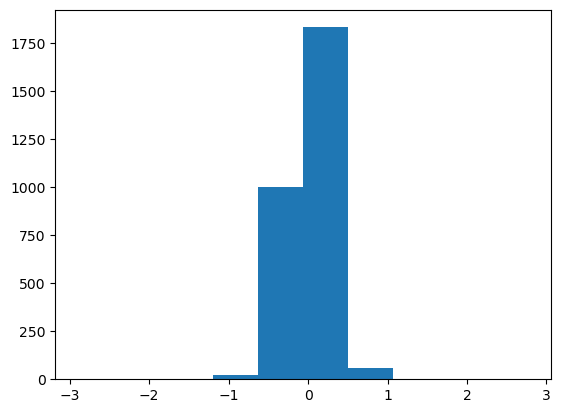

In [14]:
dh = np.ediff1d(heading, to_end=0)
_, dh = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones_like(heading), dh))
# dh[:-1] = np.angle(np.exp(1j*heading[1:])*np.exp(1j*heading[:-1]))
fig, ax = plt.subplots()
ax.hist(dh)
rot_mask = np.abs(dh)>np.pi/32
# print(np.pi/16)

0.025950811493188557 0.16064635530816385


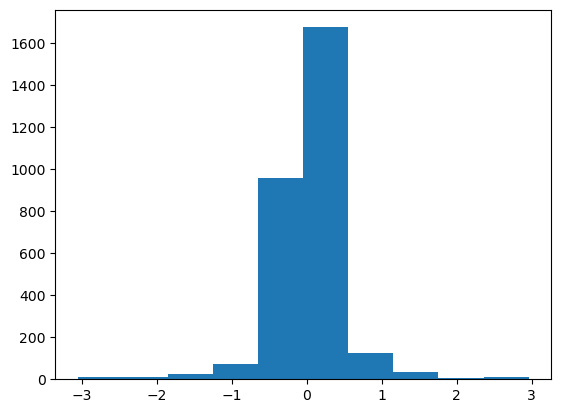

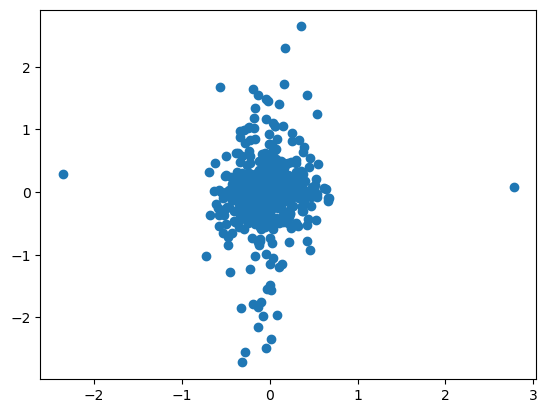

In [15]:
dphi = np.ediff1d(phi, to_end=0)
_, dphi = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones_like(heading), dphi))

fig, ax = plt.subplots()
ax.hist(dphi)

# _mask = (np.abs(dphi)<np.pi/2)*(np.abs(dh)>0.01)

fig, ax = plt.subplots()
ax.scatter(dh[mask], dphi[mask])
r,p = sp.stats.pearsonr(dh, dphi)
print(r,p)

Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2', ' Heading_cartx', ' Heading_carty', ' Arena DAC1_cartx',
       ' Arena DAC1_carty'],
      dtype='object')
(1, 16, 2924) (2924,)


(array([103.,  68.,  68.,  57.,  43.,  45.,  95., 119.,  98., 103.]),
 array([-3.14116798, -2.51424588, -1.88732378, -1.26040168, -0.63347958,
        -0.00655748,  0.62036462,  1.24728672,  1.87420882,  2.50113092,
         3.12805302]),
 <BarContainer object of 10 artists>)

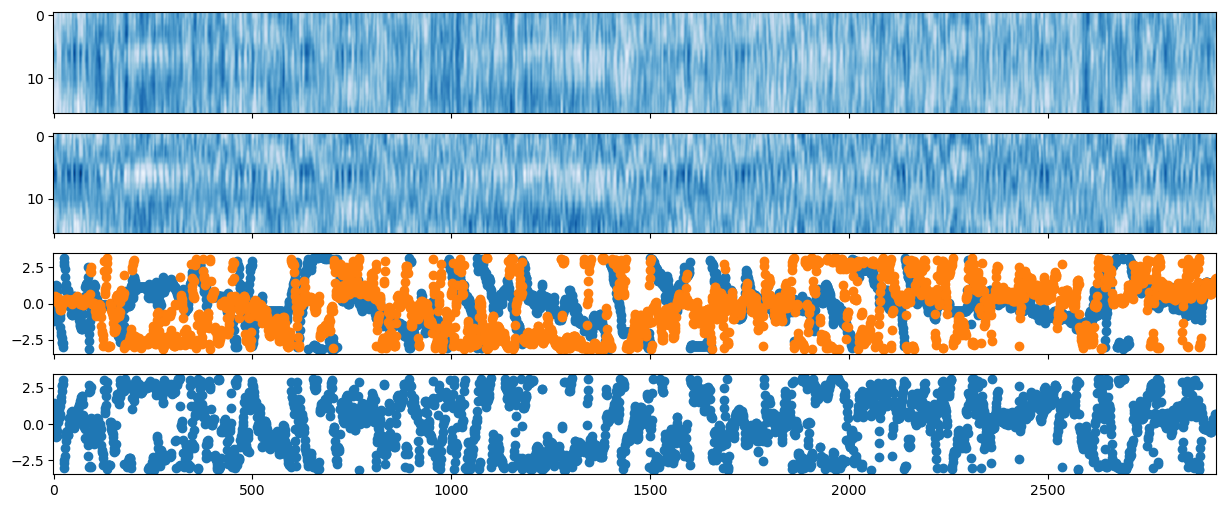

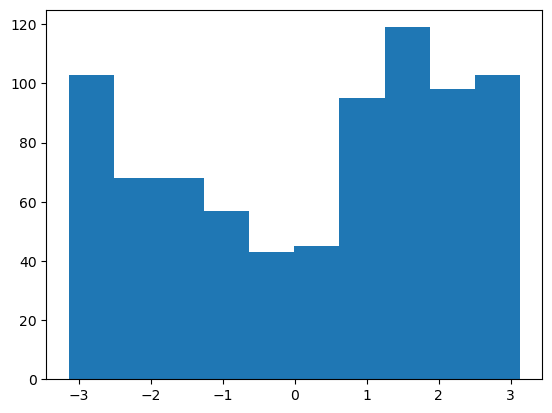

In [16]:
fig, ax= plt.subplots(4,1, figsize=[15,6], sharex=True)
ax[0].imshow(y_sm[0,::-1,:], aspect='auto', cmap= 'Blues', vmin=-.2, vmax=.2)
ax[1].imshow(y_sm[0,::-1,:]-y_sm[0,:,:].mean(axis=0,keepdims=True), aspect='auto', cmap= 'Blues') #, vmin=-2, vmax=2)
# ax.scatter(np.arange(y.shape[-1]), 15*(phi+np.pi)/2/np.pi)

print(pp.voltage_recording_aligned.columns)
# fig, ax= plt.subplots()

x = np.arange(y.shape[-1])
print(y.shape, heading.shape)
ax[2].scatter(x,heading)
ax[2].scatter(x, phi)
ax[3].scatter(x, offset)

# mask = np.abs(heading)> 1.5
fig, ax= plt.subplots()
ax.hist(offset[mask]) 


(16,) (16,)


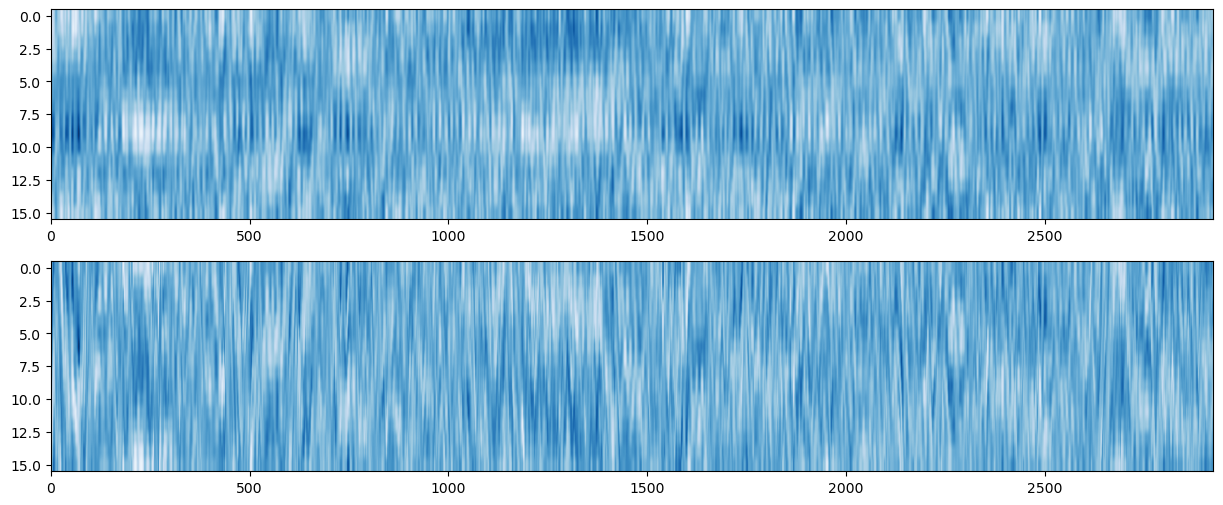

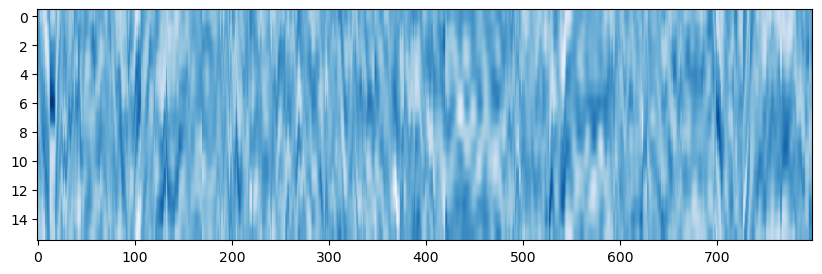

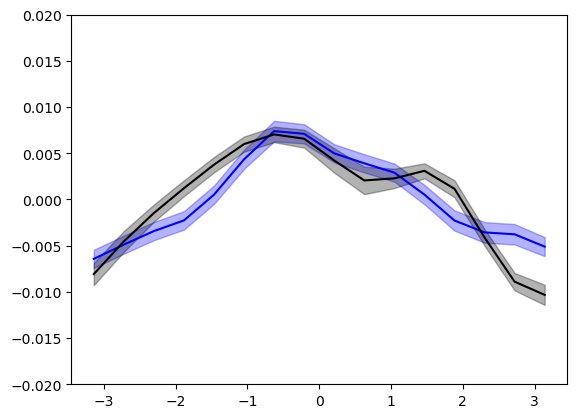

In [17]:
heading_ind = ((n_rois-1)*(heading+np.pi)/2/np.pi).astype(int)
# print(heading_ind, y_sm.shape)

y_sm_heading_aligned = np.zeros_like(y_sm)
for ind in range(heading.shape[0]):
    y_sm_heading_aligned[0,:,ind] = np.roll(y_sm[0,:,ind], -heading_ind[ind])
    
# y_sm_heading_aligned = y_sm_heading_aligned/np.linalg.norm(y_sm_heading_aligned, axis=1)
y_sm_heading_aligned = y_sm_heading_aligned - y_sm_heading_aligned.mean(axis=1)


fig, ax= plt.subplots(2,1, figsize=[15,6])
ax[0].imshow(y_sm[0,:, :] - y_sm[0,:,:].mean(axis=0,keepdims=True), cmap='Blues',aspect='auto')
ax[1].imshow(y_sm_heading_aligned[0,:,:], cmap='Blues',aspect='auto')

# y_sm_ha = y
mu = y_sm_heading_aligned[:,:,mask].mean(axis=-1)[0,:]
sem = sp.stats.sem(y_sm_heading_aligned[:,:,mask], axis=-1)[0,:]
print(mu.shape, sem.shape)
fig, ax = plt.subplots(figsize=[10,3])
ax.imshow(y_sm_heading_aligned[0,:,mask].T, cmap='Blues', aspect='auto')

fig, ax= plt.subplots()
ax.fill_between(np.linspace(-np.pi, np.pi, num=n_rois), mu-sem, mu+sem, alpha=.3, color='blue')
ax.plot(np.linspace(-np.pi, np.pi, num=n_rois), mu, color='blue')
ax.set_ylim([-.02,.02])


_mu = (y_sm[:,:,mask] - y_sm[:,:,mask].mean(axis=1,keepdims=True)).mean(axis=-1)[0,:]
_sem = sp.stats.sem(y_sm[:,:,mask]-y_sm[:,:,mask].mean(axis=1, keepdims=True), axis=-1)[0,:]
ax.fill_between(np.linspace(-np.pi, np.pi, num=n_rois), _mu-_sem, _mu+_sem, alpha=.3, color='black')
ax.plot(np.linspace(-np.pi, np.pi, num=n_rois), _mu, color='black')
# rng = np.random.default_rng()
# mu_shuff = np.zeros([n_rois,1000])
# y_sm_dm = y_sm - y_sm.mean(axis=1,keepdims=True)
# for s in range(1000):
#     head_shuff = np.roll(heading_ind, rng.integers(0,y_sm.shape[-1]))
#     y_h_shuff = np.zeros_like(y_sm)
#     for ind in range(heading.shape[0]):
#         y_h_shuff[0,:,ind] = np.roll(y_sm_dm[0,:,ind], -head_shuff[ind])
                         
#     mu_shuff[:,s] = y_h_shuff.mean(axis=-1)[0,:]


# _mu = mu_shuff.mean(axis=-1)
# _lb, _ub = np.nanpercentile(mu_shuff, 2.5, axis=-1), np.nanpercentile(mu_shuff, 97.5, axis=-1)

# ax.fill_between(np.linspace(-np.pi, np.pi, num=n_rois), _lb, _ub, alpha=.3, color='black')
# ax.plot(np.linspace(-np.pi, np.pi, num=n_rois), mu_shuff.mean(axis=-1), color='black')

0.7766139952249934


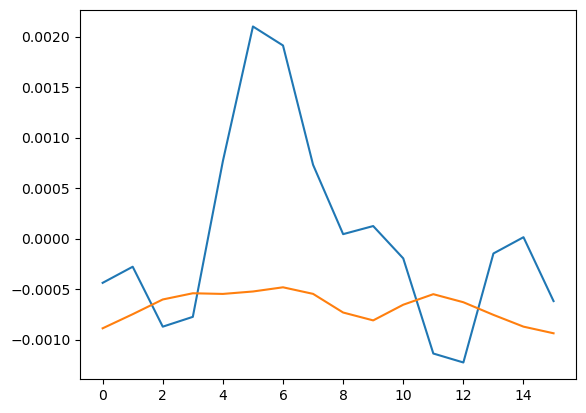

In [18]:
heading_bins = np.linspace(-np.pi, np.pi, num=17)
heading_dig = np.digitize(heading, heading_bins)-1
occ = np.bincount(heading_dig)
occ = occ/occ.sum(keepdims=True)

weights = 1-occ
# print(weights)
offset_var = 0
heading_weights = np.zeros_like(heading)
for b in range(16):
    
    mask = heading_dig==b
    heading_weights[mask]=weights[b]
    offset_var += sp.stats.circvar(offset[mask])
offset_var /= 16
# print(heading_weights)

y_ha_weighted = y_sm_heading_aligned*heading_weights[np.newaxis,np.newaxis,:]
fig, ax = plt.subplots()
ax.plot(y_ha_weighted.mean(axis=-1).ravel())

ax.plot((y_sm-y_sm.mean(axis=-1,keepdims=True)*heading_weights[np.newaxis,np.newaxis,:]).mean(axis=-1).ravel())
    
# print(y_sm_heading_aligned.shape, heading.shape)
print(offset_var)

In [18]:
print(sp.stats.circvar(offset))

0.9100515949706385


In [19]:
y_autocorr = np.nan*np.zeros([1,y.shape[1]-1,y.shape[2]])
for t in range(y.shape[-1]):
    if mask[t]:
        
        data = y[0,:,t]


        # Calculate Pearson autocorrelation for different lags
        max_lag = data.shape[0] 
        y_autocorr[0,:,t] = [sp.stats.pearsonr(data, np.roll(data,i,axis=0))[0] for i in range(1,max_lag)]


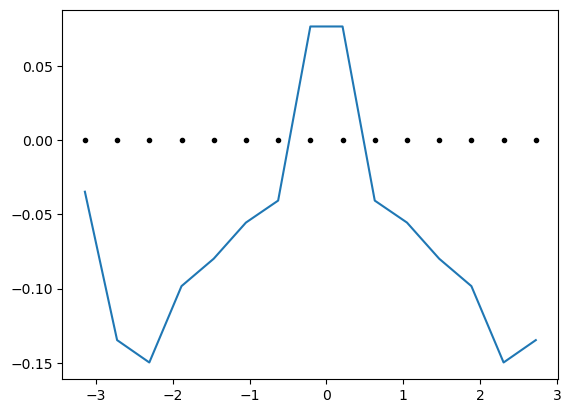

In [21]:
fig, ax = plt.subplots()
ax.plot(np.arange(-np.pi,np.pi,2*np.pi/15),np.roll(np.nanmean(y_autocorr[0,:,:], axis=-1),8))
ax.plot(np.arange(-np.pi,np.pi,2*np.pi/15), np.zeros([15,]),'k.')
# ax.imshow(y_autocorr[0,10:,], aspect='auto')